In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters_gaussians.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
Meshcat url:  http://127.0.0.1:7003/static/


In [22]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 10
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in range(N_samples):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

draw_scene_tree_contents_meshcat(samples[0][0], zmq_url=vis.window.zmq_url, prefix="sample")

Loaded 10 scenes.


In [27]:
# Initialize a grammar with wide parameter guesses.
grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)

def do_vis(tree):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_in_progress")
    
def get_posterior_tree_samples_from_observation(
            grammar, observed_nodes, verbose=0,
            num_samples=20, subsample_step=1, hmc_strategy="NUTS"):
    draw_scene_tree_contents_meshcat(
        SceneTree.make_from_observed_nodes(observed_nodes), zmq_url=vis.window.zmq_url, prefix="observed"
    )
    
    # Use a MIP to get MAP structure.
    mip_results = infer_mle_tree_with_mip(
        grammar, observed_nodes, verbose=verbose>1, max_scene_extent_in_any_dir=10.
    )
    mip_optimized_tree = get_optimized_tree_from_mip_results(mip_results)
    if not mip_optimized_tree:
        return None
    
    draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
                                      
    # Use NLP to refine that to a MAP estimate.
    refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=verbose>1)
    refined_tree = refinement_results.refined_tree
    
    # And sample trees around that MAP estimate with the
    # same structure.
    # Langevin-esque:
    if hmc_strategy=="langevin":
        sampled_trees = do_fixed_structure_hmc_with_constraint_penalties(
            grammar, tree, num_samples=num_samples, subsample_step=subsample_step, verbose=verbose,
            kernel_type="HMC", num_steps=1, step_size=1E-3, adapt_step_size=True
        )
    # NUTS, defaults except limiting tree depth, to save on calls to
    # the slow model. Much slower, but should theoretically get much more
    # diversity as long as it doesn't diverge.
    elif hmc_strategy=="NUTS":
        sampled_trees = do_fixed_structure_hmc_with_constraint_penalties(
            grammar, tree, num_samples=num_samples, subsample_step=subsample_step, verbose=verbose,
            kernel_type="NUTS", max_tree_depth=4
        )
    else:
        raise ValueError(hmc_strategy)
    
    
    # Finally, subsample the sampled trees as requested and return
    # the sampled set.
    return sampled_trees

def collect_posterior_sample_sets(grammar, observed_node_sets):
    posterior_sample_sets = []
    for observed_nodes in tqdm(observed_node_sets, desc='Collecting posterior samples'):
        posterior_samples = get_posterior_tree_samples_from_observation(
            grammar, observed_nodes, verbose=0, hmc_strategy="langevin", num_samples=100, subsample_step=5)
        if posterior_samples is not None:
            posterior_sample_sets.append(posterior_samples)
    return posterior_sample_sets

if 0:
    posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)
    for k, tree in enumerate(posterior_sample_sets[-1]):
        draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="guesses/%d" % k)

In [28]:
torch.save(grammar, "/tmp/test_saved_grammar.torch")
orig_grammar = torch.load("/tmp/test_saved_grammar.torch")

In [29]:
if 0:
    grammar = fit_grammar_params_to_sample_sets_with_uninformative_prior(grammar, posterior_sample_sets)
    print("**********************************\n"
          "**********  BEFORE ***************\n"
          "************************************")
    orig_grammar.print_params(node_names=["Desk"])
    print("**********************************\n"
          "**********  AFTER ***************\n"
          "************************************")
    grammar.print_params(node_names=["Desk"])
    print("**********************************\n"
          "**********  TRUTH ***************\n"
          "************************************")
    ground_truth_grammar.print_params(node_names=["Desk"])

In [30]:
state_dict_history = []
for iter_k in tqdm(range(3), desc="Major iteration"):
    state_dict_history.append(deepcopy(grammar.state_dict()))
    posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)
    grammar = fit_grammar_params_to_sample_sets_with_uninformative_prior(grammar, posterior_sample_sets)
state_dict_history.append(deepcopy(grammar.state_dict()))

Sample: 100%|██████████| 110/110 [00:04, 24.66it/s, step size=2.90e-03, acc. prob=0.953]


Sample: 100%|██████████| 110/110 [00:04, 24.76it/s, step size=3.35e-03, acc. prob=0.919]


Sample: 100%|██████████| 110/110 [00:04, 24.41it/s, step size=3.43e-03, acc. prob=0.919]


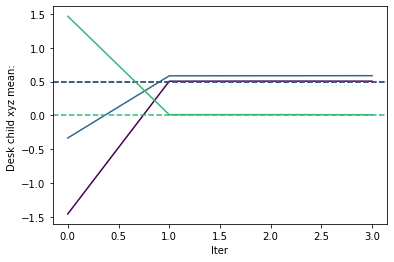

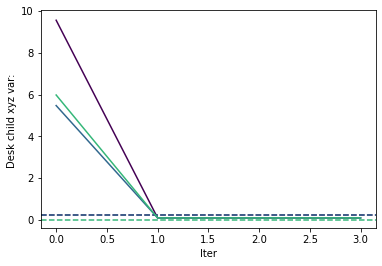

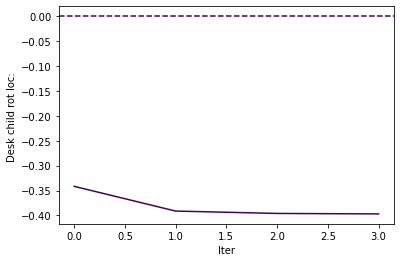

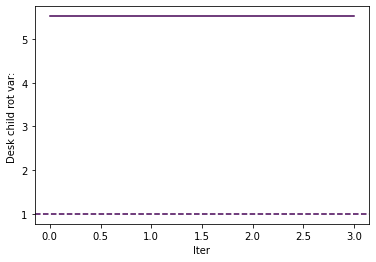

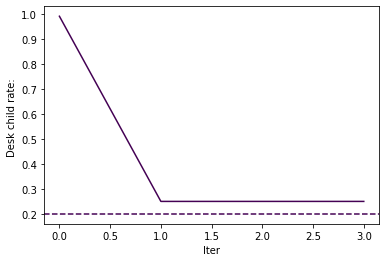

In [32]:
# Plot a couple of interesting parameters
param_getters_of_interest = {
    "Desk child xyz mean: ": lambda x: x.rule_params_by_node_type["Desk"][0][0]["mean"]().detach().numpy(),
    "Desk child xyz var: ": lambda x: x.rule_params_by_node_type["Desk"][0][0]["variance"]().detach().numpy(),
    "Desk child rot loc: ": lambda x: x.rule_params_by_node_type["Desk"][0][1]["loc"]().detach().numpy(),
    "Desk child rot var: ": lambda x: x.rule_params_by_node_type["Desk"][0][1]["concentration"]().detach().numpy(),
    "Desk child rate: ": lambda x: x.params_by_node_type["Desk"]().detach().numpy()
}

for key, getter in param_getters_of_interest.items():
    plt.figure()
    history = []
    for state_dict in state_dict_history:
        grammar.load_state_dict(state_dict)
        history.append(getter(grammar).copy().flatten())
    data = np.stack(history)

    gt_x = getter(ground_truth_grammar).flatten()
    cm = plt.get_cmap("viridis")
    N = len(gt_x)
    for k in range(N):
        color = cm(k / max(1, N))
        plt.plot(data[:, k], color=color)
        plt.axhline(gt_x[k], color=color, linestyle="--")
    plt.xlabel("Iter")
    plt.ylabel(key)
